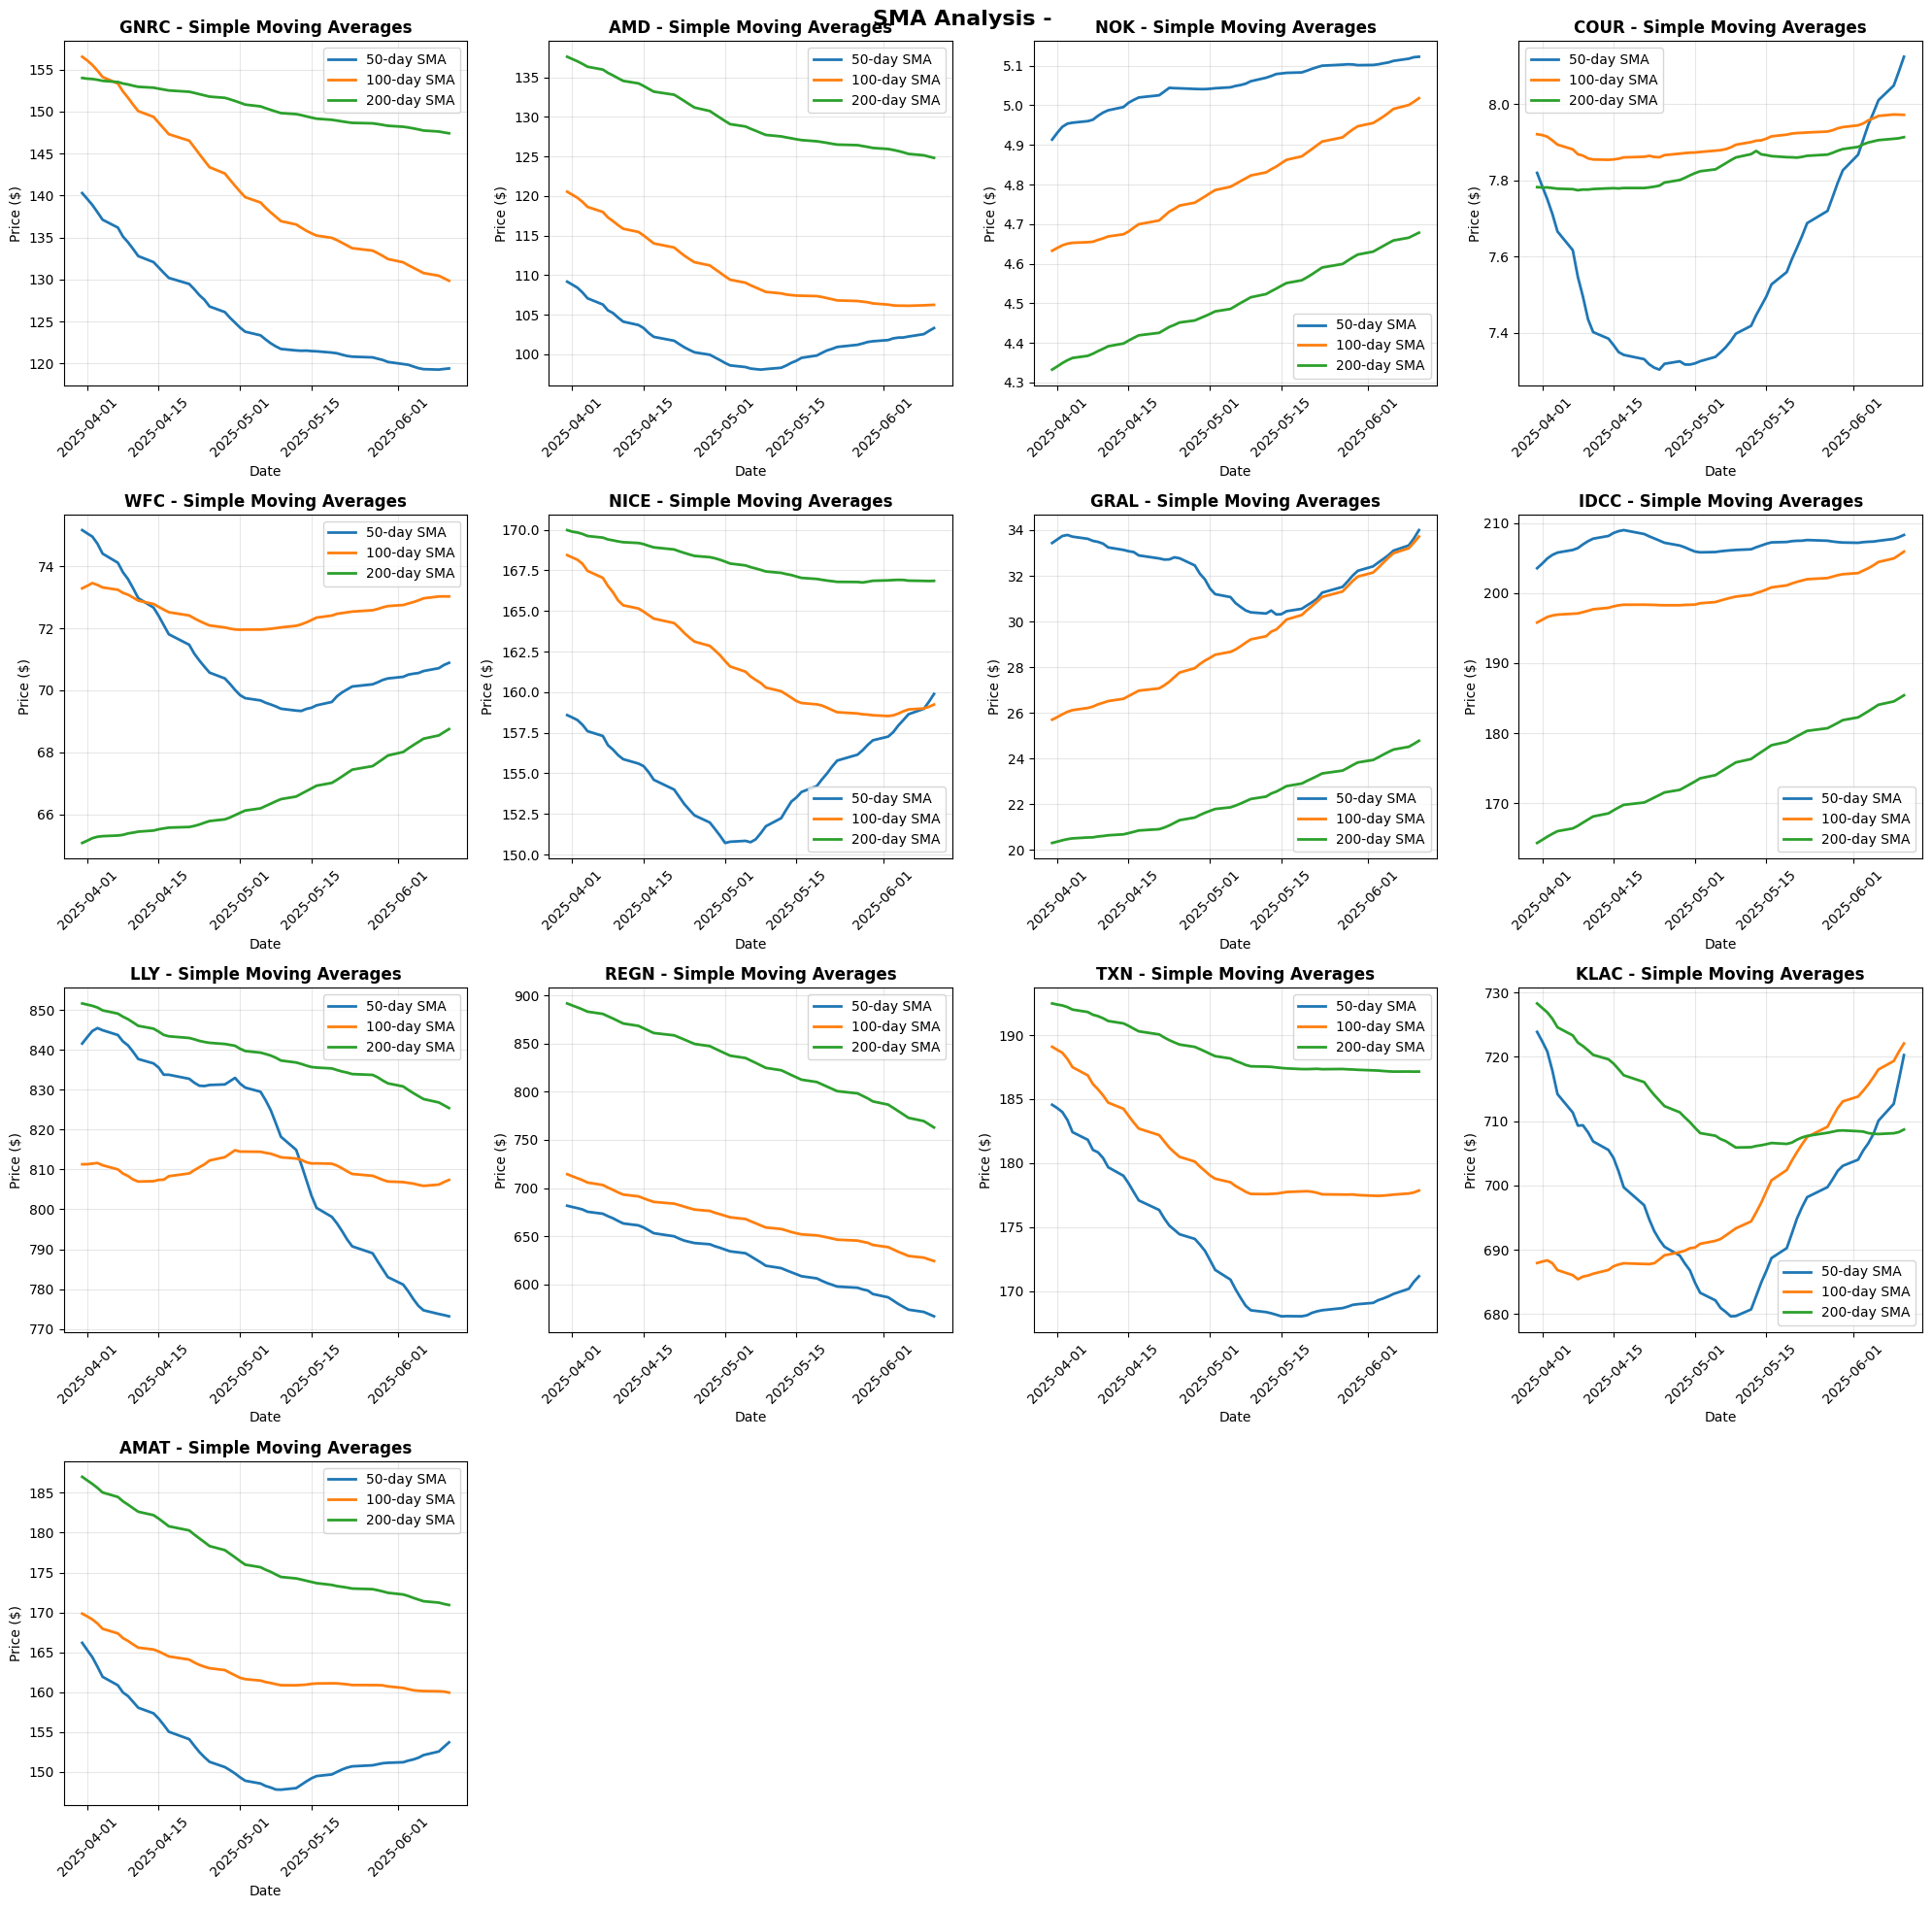

 Relative strength for TXN in Q2_2025: 30.388337044641577
 Relative strength for TXN in April: 29.088076066590023
 Relative strength for TXN in May: 30.74737580422045
 Relative strength for TXN in June: 32.35927754691025
 Relative strength for AMAT in Q2_2025: 27.235861098737352
 Relative strength for AMAT in April: 26.499370751087802
 Relative strength for AMAT in May: 27.764560716549546
 Relative strength for AMAT in June: 27.78098468887012
 Relative strength for COUR in Q2_2025: 1.4362316778525694
 Relative strength for COUR in April: 1.3413585973053919
 Relative strength for COUR in May: 1.5117592690230641
 Relative strength for COUR in June: 1.4956996729712395
 Relative strength for GNRC in Q2_2025: 21.20934803020286
 Relative strength for GNRC in April: 21.10544181691466
 Relative strength for GNRC in May: 21.201766323939903
 Relative strength for GNRC in June: 21.305406557630697
 Relative strength for IDCC in Q2_2025: 36.94398699661601
 Relative strength for IDCC in April: 36.76

In [50]:
from yfinance import *
import pandas as pd
from alpha_vantage.techindicators import TechIndicators
from alpha_vantage.timeseries import TimeSeries
import matplotlib.pyplot as plt
import yfinance as yf

"""
We need to:
    - Calculate SMA over 50 -> 100 -> 200 day periods
    - Compile that data into a CSV
    - Calculate RS% over same periods (Also: April, May, June)
    - Do not include market bottom (Apr 17)
    - Stocks: TXN, AMAT, COUR, GNRC, IDCC, LLY, NICE, NOK, WFC, REGN, AMD, GRAL, KLAC
    - Compare to SPY

"""
# Periods of time
time_periods = {
    'Q2_2025': ('2025-03-31', '2025-06-11'),
    'April': ('2025-04-01', '2025-04-30'),
    'May': ('2025-05-01', '2025-05-31'),
    'June': ('2025-06-01', '2025-06-11')
}

# Initialize index data
market = 'SPY'
index = Ticker('SPY')
index_data = index.history(period="ytd")

# Stocks
stock_tickers = ['TXN', 'AMAT', 'COUR', 'GNRC', 'IDCC', 'LLY', 'NICE', 'NOK', 'WFC', 'REGN', 'AMD', 'GRAL', 'KLAC']

# Pull AlphaVantageAPI
ts = TimeSeries(key="00WPSKG93DBMYOOR")
ti = TechIndicators(key='00WPSKG93DBMYOOR', output_format='pandas')

# Initialize 50, 100, 200 data for stocks (yFinance)
def initialize_sma_data(tickers, time_period, periods=[50,100,200]):
    sma_data = {}
    start, end = time_period
    for ticker in tickers:
            stock = yf.Ticker(ticker)
            data = stock.history(period="1y") # 2y historical data, enough for 200day

            for period in periods:
                sma_key = f'{ticker}_{period}_sma' # Looks like ex: TXN_50_sma
                sma = data['Close'].rolling(window=period).mean()  # Calculates SMA

                # Filter by date
                sma_data[sma_key] = sma.loc[start:end]

    return sma_data

# Insert data into separate variables based on time periods
sma_data_q2 = initialize_sma_data(stock_tickers, time_periods['Q2_2025'])
sma_data_april = initialize_sma_data(stock_tickers, time_periods['April'])
sma_data_may = initialize_sma_data(stock_tickers, time_periods['May'])
sma_data_june = initialize_sma_data(stock_tickers, time_periods['June'])

# Then into dataframes
q2_df = pd.DataFrame(sma_data_q2)
april_df = pd.DataFrame(sma_data_april)
may_df = pd.DataFrame(sma_data_may)
june_df = pd.DataFrame(sma_data_june)

# Plots
def plot_all_sma(df, period_name=""):
    stocks = list(set([col.split('_')[0] for col in df.columns]))

    # Subplots
    n_stocks = len(stocks)
    cols = 4  # 4 plots per row
    rows = (n_stocks + cols - 1) // cols  # ceiling

    fig, axes = plt.subplots(rows, cols, figsize=(20, 5*rows))
    fig.suptitle(f'SMA Analysis - {period_name}', fontsize=16, fontweight='bold')

    # flatten axes
    if rows == 1:
        axes = [axes] if cols == 1 else axes
    else:
        axes = axes.flatten()

    for i, stock in enumerate(stocks):
        ax = axes[i]

        # Plot each SMA in one plot for stock
        for period in [50, 100, 200]:
            col_name = f'{stock}_{period}_sma'
            if col_name in df.columns:
                ax.plot(df.index, df[col_name], label=f'{period}-day SMA', linewidth=2)

        ax.set_title(f'{stock} - Simple Moving Averages', fontweight='bold')
        ax.set_xlabel('Date')
        ax.set_ylabel('Price ($)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45)

    # Hide empty subplots
    for j in range(n_stocks, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


plot_all_sma(q2_df)


# And CSVs
q2_df.to_csv('q2_sma_df.csv')
april_df.to_csv('april_sma_df.csv')
may_df.to_csv('may_sma_df.csv')
june_df.to_csv('june_sma_df.csv')

# Relative strength vs. index (SPY)
# Formula: Price of Security A / Price of Security B (SPY) * 100


def initialize_rs_data(ticker, time_period):
    # Go through all data (close price) month to month & calculate RS
    start, end = time_period
    stock = Ticker(ticker)
    data = stock.history(period="ytd")

    # Clean data based off time_period
    timed_data = data.loc[start:end]
    timed_index = index_data.loc[start:end]

    # Averages & Relative Strength Calculation
    index_avg = sum(timed_index['Close']) / len(timed_index['Close'])
    close_avg = sum(timed_data['Close']) / len(timed_data['Close'])

    relative_strength = (close_avg / index_avg) * 100

    return relative_strength

# Print all RS for our stocks
def show_all_rs_data():
    for stock in stock_tickers:
        print(f" Relative strength for {stock} in Q2_2025: {initialize_rs_data(stock, time_periods['Q2_2025'])}")
        print(f" Relative strength for {stock} in April: {initialize_rs_data(stock, time_periods['April'])}")
        print(f" Relative strength for {stock} in May: {initialize_rs_data(stock, time_periods['May'])}")
        print(f" Relative strength for {stock} in June: {initialize_rs_data(stock, time_periods['June'])}")

show_all_rs_data()





